# **Extracting and analyzing data form `Eurostat`**

## **Requirements**

In [1]:
import requests
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

## **Extracting the data**

In [2]:
# Construct the URL according to Eurostat's API documentation specifics.
url = 'https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/ei_bsco_m?format=JSON&unit=BAL&indic=BS-CSMCI&s_adj=SA&lang=en'
# Send a request to the Eurostat API
response = requests.get(url)
data_json = response.json()  

## **Processing the data**

In [3]:
indicator_dict = data_json['value']
geo_dict = data_json['dimension']['geo']['category']['index']
geo_dict_2 = data_json['dimension']['geo']['category']['label']
time_dict = data_json['dimension']['time']['category']['index']

n_time_ids = len(time_dict)
def indicator_id(geo_id, time_id):
    result = geo_id*n_time_ids + time_id
    return result

value_list = list()
geo_list = list()
time_list = list()
geo_values = [x for x in geo_dict.keys()]
time_values = [x for x in time_dict.keys()]
time_id_nan = data_json['extension']['positions-with-no-data']['time']

for geo_id in geo_dict.values() :
    for time_id in time_dict.values() :
        if time_id not in time_id_nan:

            value_id = str(indicator_id(geo_id, time_id))

            if value_id in indicator_dict.keys():

                value_list.append(indicator_dict[value_id])
                geo_list.append(geo_dict_2[geo_values[geo_id]])
                time_list.append(time_values[time_id])

value_geo_time_dict = dict()
value_geo_time_dict['indicator'] = value_list
value_geo_time_dict['geo'] = geo_list
value_geo_time_dict['date'] = time_list

df = pd.DataFrame(value_geo_time_dict)
df['geo'] = df['geo'].replace({'European Union - 27 countries (from 2020)' : 'EU'})
df_geo = dict()
df_geo_2022 = dict()
df_geo_last_years = dict()
avg_indicator_groupby_year = dict()
df_geo_last_years_2022 = dict()
for geo in df['geo'].unique() :
    df_geo[geo] = df.loc[df['geo'] == geo]
    df_geo_2022[geo] = df_geo[geo].loc[(df_geo[geo]['date'] >= '2022-01') & (df_geo[geo]['date'] <= '2022-12'),:]
    df_geo_last_years[geo] = df_geo[geo].loc[(df_geo[geo]['date'] >= '2017-01') & (df_geo[geo]['date'] <= '2021-12'),:]
    df_geo_last_years[geo].loc[:,'year'] = df_geo_last_years[geo]['date'].apply(lambda x : x[0:4])
    avg_indicator_groupby_year[geo] = df_geo_last_years[geo].groupby('year').mean('indicator').reset_index()
    df_geo_last_years_2022[geo] = pd.concat([avg_indicator_groupby_year[geo].rename(columns={'year':'date'}), df_geo_2022[geo]]).drop('geo', axis=1)
    avg_indicator_groupby_year[geo]  =  avg_indicator_groupby_year[geo].rename(columns={'indicator': 'avg_indicator'})

In [4]:
selected_geos = ['EU', 'Spain', 'Sweden', 'Italy', 'France', 'Portugal', 'Denmark', 'Germany']

print('---------------------------------------------------------------------------------------')

print('Selected Countries for the analysis: ', selected_geos)

print('--------------------------------------------------------------------------------------')

print('Just for getting and idea of how the dictionaries of data-frames generated from Eurostat looks like (they will be run only with EU and Spain, just for simplicity):')

print('---------------------------------------------------------------------------------------')

for geo in ['EU', 'Spain']:

    print(f'df_geo[{geo}]\n')
    print(df_geo[geo])
    print('---------------------------------------------------------------------------------------')
    print(f'df_geo_2022[{geo}]\n')
    print(df_geo_2022[geo])
    print('---------------------------------------------------------------------------------------')
    print(f'avg_indicator_groupby_year[{geo}]\n')
    print(avg_indicator_groupby_year[geo])
    print('---------------------------------------------------------------------------------------')
    print(f'df_geo_last_years_2022[{geo}]\n')
    print(df_geo_last_years_2022[geo])
    print('---------------------------------------------------------------------------------------')


print('---------------------------------------------------------------------------------------')


#################################################################

---------------------------------------------------------------------------------------
Selected Countries for the analysis:  ['EU', 'Spain', 'Sweden', 'Italy', 'France', 'Portugal', 'Denmark', 'Germany']
--------------------------------------------------------------------------------------
Just for getting and idea of how the dictionaries of data-frames generated from Eurostat looks like (they will be run only with EU and Spain, just for simplicity):
---------------------------------------------------------------------------------------
df_geo[EU]

     indicator geo     date
0        -10.3  EU  1985-01
1        -10.7  EU  1985-02
2        -11.5  EU  1985-03
3        -10.9  EU  1985-04
4        -11.3  EU  1985-05
..         ...  ..      ...
466      -17.5  EU  2023-11
467      -15.9  EU  2023-12
468      -16.2  EU  2024-01
469      -15.8  EU  2024-02
470      -15.2  EU  2024-03

[471 rows x 3 columns]
------------------------------------------------------------------------------------

## **Plotting the results**

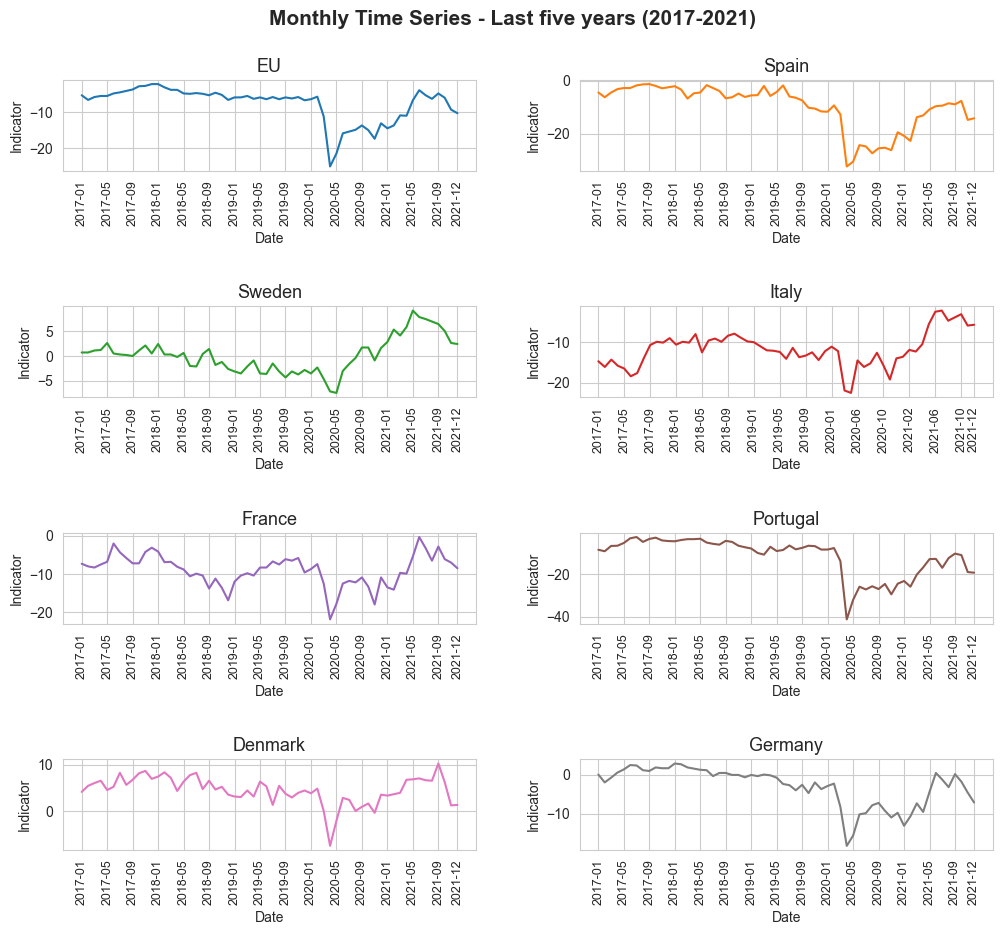

In [21]:
# Define the number of rows and columns for the matrix plot
num_cols = 2  # You can adjust the number of columns as needed
num_rows = int(np.ceil(len(selected_geos) / num_cols))

# Create a subplot with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

colors = sns.color_palette("tab10", len(selected_geos))

# Loop through each 'geo' and create a subplot in the matrix
for (i, geo), color in zip(enumerate(selected_geos), colors) :
    ax = axes[i]  # Get the current axis
    sns.lineplot(x="date", y="indicator", data=df_geo_last_years[geo], color=color, ax=ax)
    ax.set_title(f"{geo}", fontsize=13)
    xticks_index = np.arange(0, len(df_geo_last_years[geo]), 4)
    xticks_index = xticks_index.tolist()
    xticks_index.append(len(df_geo_last_years[geo])-1)
    ax.set_xticks(xticks_index)
    ax.tick_params(axis='x', rotation=90, labelsize=9)
    ax.set_xlabel('Date')
    ax.set_ylabel('Indicator')

# Remove any unused subplots in case the number of 'geo' values is less than num_rows * num_cols
for j in range(len(selected_geos), num_rows * num_cols):
    fig.delaxes(axes[j])

plt.suptitle('Monthly Time Series - Last five years (2017-2021)', fontsize=15, y=0.95, weight='bold') # Establishing a general tittle for the plot.
plt.subplots_adjust(hspace=1.5, wspace=0.25) # Adjust vertical (hspace) and horizontal (wspace) spacing
# fig.savefig('mothly_time_series_last_five_years' + '.jpg', format='jpg', dpi=550)
# plt.tight_layout()
plt.show()

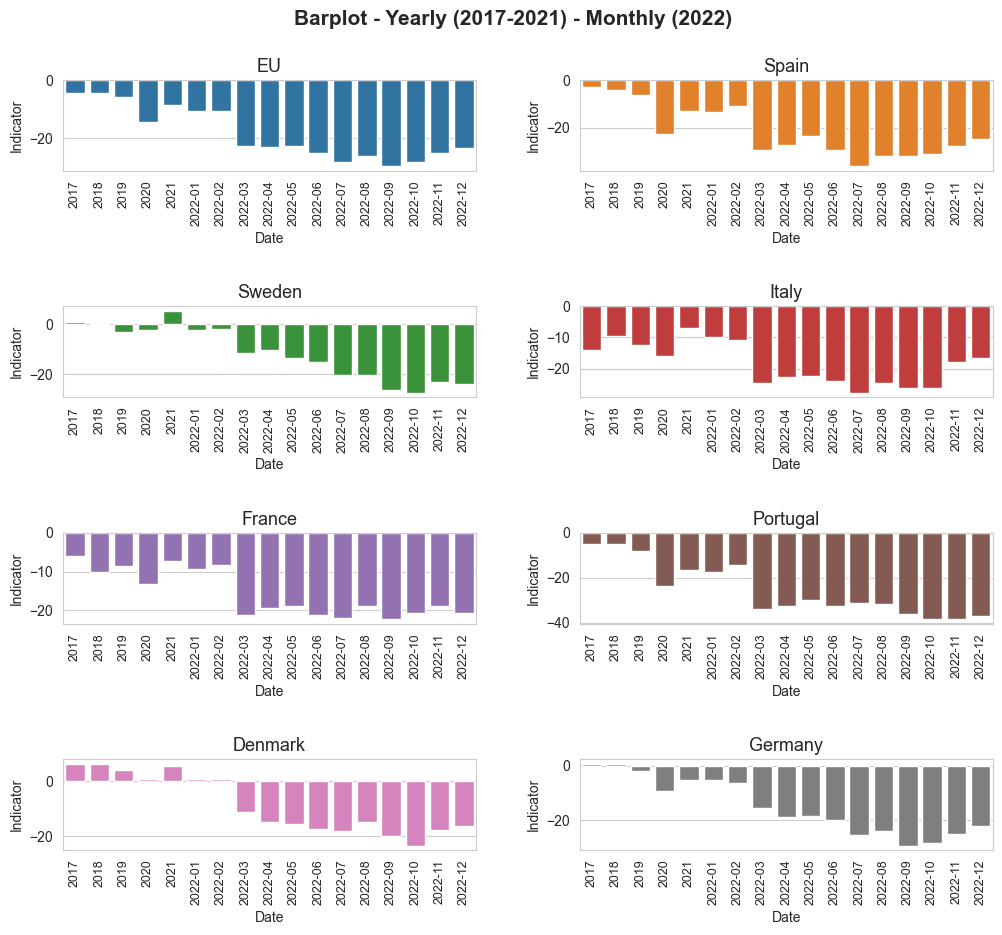

In [20]:
# Define the number of rows and columns for the matrix plot
num_cols = 2  # You can adjust the number of columns as needed
num_rows = int(np.ceil(len(selected_geos) / num_cols))

# Create a subplot with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

colors = sns.color_palette("tab10", len(selected_geos))

# Loop through each 'geo' and create a subplot in the matrix
for (i, geo), color in zip(enumerate(selected_geos), colors) :
    ax = axes[i]  # Get the current axis
    sns.barplot(x="date", y="indicator", data=df_geo_last_years_2022[geo], color=color, ax=ax)
    ax.set_title(f"{geo}", fontsize=13)
    xticks_index = np.arange(0, len(df_geo_last_years_2022[geo]), 1)
    ax.set_xticks(xticks_index)
    ax.tick_params(axis='x', rotation=90, labelsize=9)
    ax.set_xlabel('Date')
    ax.set_ylabel('Indicator')

# Remove any unused subplots in case the number of 'geo' values is less than num_rows * num_cols
for j in range(len(selected_geos), num_rows * num_cols):
    fig.delaxes(axes[j])

plt.suptitle('Barplot - Yearly (2017-2021) - Monthly (2022)', fontsize=15, y=0.95, weight='bold') # Establishing a general tittle for the plot.
plt.subplots_adjust(hspace=1.5, wspace=0.25) # Adjust vertical (hspace) and horizontal (wspace) spacing
# fig.savefig('barplot_last_five_years_and_2022' + '.jpg', format='jpg', dpi=550)
# plt.tight_layout()
plt.show()